# Librerías

In [1]:
# ! pip install optuna
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, r2_score, recall_score, f1_score
import random
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer , TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as PipelineRes
from sklearn.impute import SimpleImputer
import streamlit as st
import joblib
import warnings
warnings.simplefilter('ignore')

import shap


c:\Users\garci\OneDrive\Escritorio\TUIA\Aprendizaje Automatico 1\tp1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

Introducción:
El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas ‘RainTomorrow’ y ‘RainfallTomorrow’. El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas. 

Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

A continuación cargamos el dataset y comenzamos a realizar un análisis explotario de los datos que en el se encuentran.


In [2]:
### Cargamos los datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
data = pd.read_csv(file_path, sep=',',engine='python')

In [3]:
### Vista de datos
data.head()

Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0           0  2008-12-01   Albury     13.4     22.9       0.6          NaN   
1           1  2008-12-02   Albury      7.4     25.1       0.0          NaN   
2           2  2008-12-03   Albury     12.9     25.7       0.0          NaN   
3           3  2008-12-04   Albury      9.2     28.0       0.0          NaN   
4           4  2008-12-05   Albury     17.5     32.3       1.0          NaN   

   Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  \
0       NaN           W           44.0  ...        22.0      1007.7   
1       NaN         WNW           44.0  ...        25.0      1010.6   
2       NaN         WSW           46.0  ...        30.0      1007.6   
3       NaN          NE           24.0  ...        16.0      1017.6   
4       NaN           W           41.0  ...        33.0      1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

In [4]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
print(data.columns)

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

Tenemos 18 variables numéricas (enteros y flotantes) y 7 variables que son de tipo objeto, lo cual significa significa que puede contener cualquier tipo de objeto en Python, ya sea un entero, una cadena, una lista, una función, una clase, o cualquier otro objeto. Estas variables que las consideramos categóricas las trabajaremos más adelante

## Análisis exploratorio de los datos

In [6]:
data.describe().round(2)

Unnamed: 0   MinTemp    MaxTemp   Rainfall  Evaporation  Sunshine  \
count   145412.00  143928.0  144159.00  142152.00     82658.00  75616.00   
mean     72728.18      12.2      23.22       2.36         5.47      7.61   
std      41990.72       6.4       7.12       8.48         4.19      3.79   
min          0.00      -8.5      -4.80       0.00         0.00      0.00   
25%      36362.75       7.6      17.90       0.00         2.60      4.80   
50%      72727.50      12.0      22.60       0.00         4.80      8.40   
75%     109093.25      16.9      28.20       0.80         7.40     10.60   
max     145458.00      33.9      48.10     371.00       145.00     14.50   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
count      135159.00     143645.00     142351.00    142759.00    140907.00   
mean           40.04         14.04         18.66        68.88        51.54   
std            13.61          8.92          8.81        19.03        20.80   
min             6.00          0.00          0.00         0.00         0.00   
25%            31.00          7.00         13.00        57.00        37.00   
50%            39.00         13.00         19.00        70.00        52.00   
75%            48.00         19.00         24.00        83.00        66.00   
max           135.00        130.00         87.00       100.00       100.00   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm    Temp9am    Temp3pm  \
count    130351.00    130388.00  89542.00  86076.00  143646.00  141805.00   
mean       1017.65      1015.26      4.45      4.51      16.99      21.69   
std           7.11         7.04      2.89      2.72       6.49       6.94   
min         980.50       977.10      0.00      0.00      -7.20      -5.40   
25%        1012.90      1010.40      1.00      2.00      12.30      16.60   
50%        1017.60      1015.20      5.00      5.00      16.70      21.10   
75%        1022.40      1020.00      7.00      7.00      21.60      26.40   
max        1041.00      1039.60      9.00      9.00      40.20      46.70   

       RainfallTomorrow  
count         142153.00  
mean               2.36  
std                8.48  
min                0.00  
25%                0.00  
50%                0.00  
75%                0.80  
max              371.00

En esta tabla podemos ver:
- count: cantidad todal de datos
- mean: media/promedio
- std: desvio estándar
- min: valor mínimo de los datos
- máx: valor máximo de los datos
- 25%: es el primer cuartil
- 50%: es el segundo cuartil o mediana
- 75% es el tercer cuartil
- max: es el valor máximo de los datos


In [7]:
### Cantidad de valores faltantes.
data.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

In [8]:
#Otra forma de obtener la cantidad de datos nulos
data.isnull().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

Para analizar en profundidad y tratar los nulos solo vamos a tranajar con las cinco 'Locations' requeridas, que son:
- Sydney
- SydneyAirport
- Canberra
- Melbourne
- MelbourneAirport 

In [9]:
#¿Que 'Locations' posee el data set?
data.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [10]:
#Nos quemos con los datos de las 5 locations que nos interesan
data = data[data['Location'].isin(["Sydney", "SydneyAirport", "Canberra", "Melbourne", "MelbourneAirport"])]

In [11]:
data.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [12]:
data['WindDir'] = data[['WindDir3pm', 'WindDir9am', 'WindGustDir']].mode(axis=1, numeric_only=False).iloc[:, 0]
data['WindSpeed'] = data[['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']].mean(axis=1, numeric_only=False)
data['Humidity'] = data[['Humidity9am', 'Humidity3pm']].mean(axis=1, numeric_only=False)
data['Pressure'] = data[['Pressure9am', 'Pressure3pm']].mean(axis=1, numeric_only=False)
data['Cloud'] = data[['Cloud9am', 'Cloud3pm']].mean(axis=1, numeric_only=False)
data['WindSpeed'] = data[['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']].mean(axis=1, numeric_only=False)
data['MinTemp'] = data[['Temp9am', 'MinTemp']].mean(axis=1, numeric_only=False)
data['MaxTemp'] = data[['Temp3pm', 'MaxTemp']].mean(axis=1, numeric_only=False)

In [13]:
columnas_a_eliminar = ['WindDir3pm', 'WindDir9am', 'WindGustDir',
                        'WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed',
                        'Humidity9am', 'Humidity3pm',
                        'Pressure9am', 'Pressure3pm',
                        'Cloud9am', 'Cloud3pm',
                        'Temp9am', 'Temp3pm', 'Unnamed: 0']

# Eliminar las columnas originales
data.drop(columnas_a_eliminar, axis=1, inplace=True)

In [14]:
#¿Cuántos datos hay de cada ciudad?
#Esto lo podríamos ordenar de ponerlo arriba donde estan los gráficos de la cantidad de datos por ciudad (gráfico violeta)
data_country = data.value_counts('Location')

data_country.head()

Location
Canberra            3435
Sydney              3343
Melbourne           3192
MelbourneAirport    3008
SydneyAirport       3008
Name: count, dtype: int64

Realizamos un gráfico para observar la frecuencia de cada Location

<Axes: xlabel='Location'>

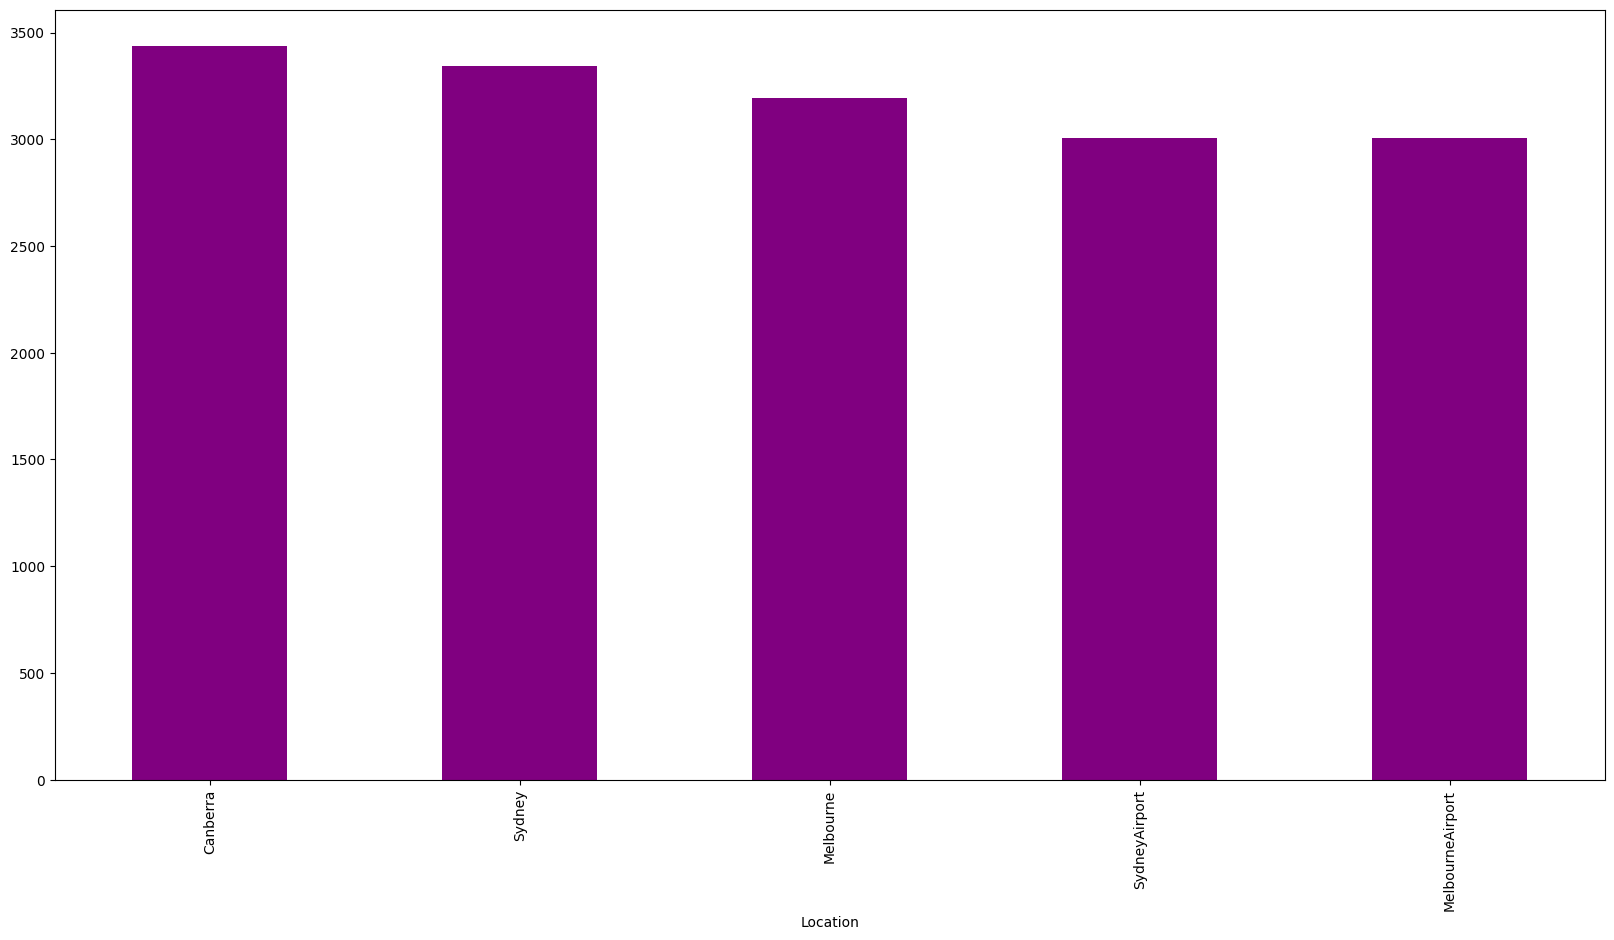

In [15]:
top = data['Location'].value_counts().sort_values(ascending=False)[0:30]

top.plot(kind='bar', color = 'purple', figsize=(20, 10))

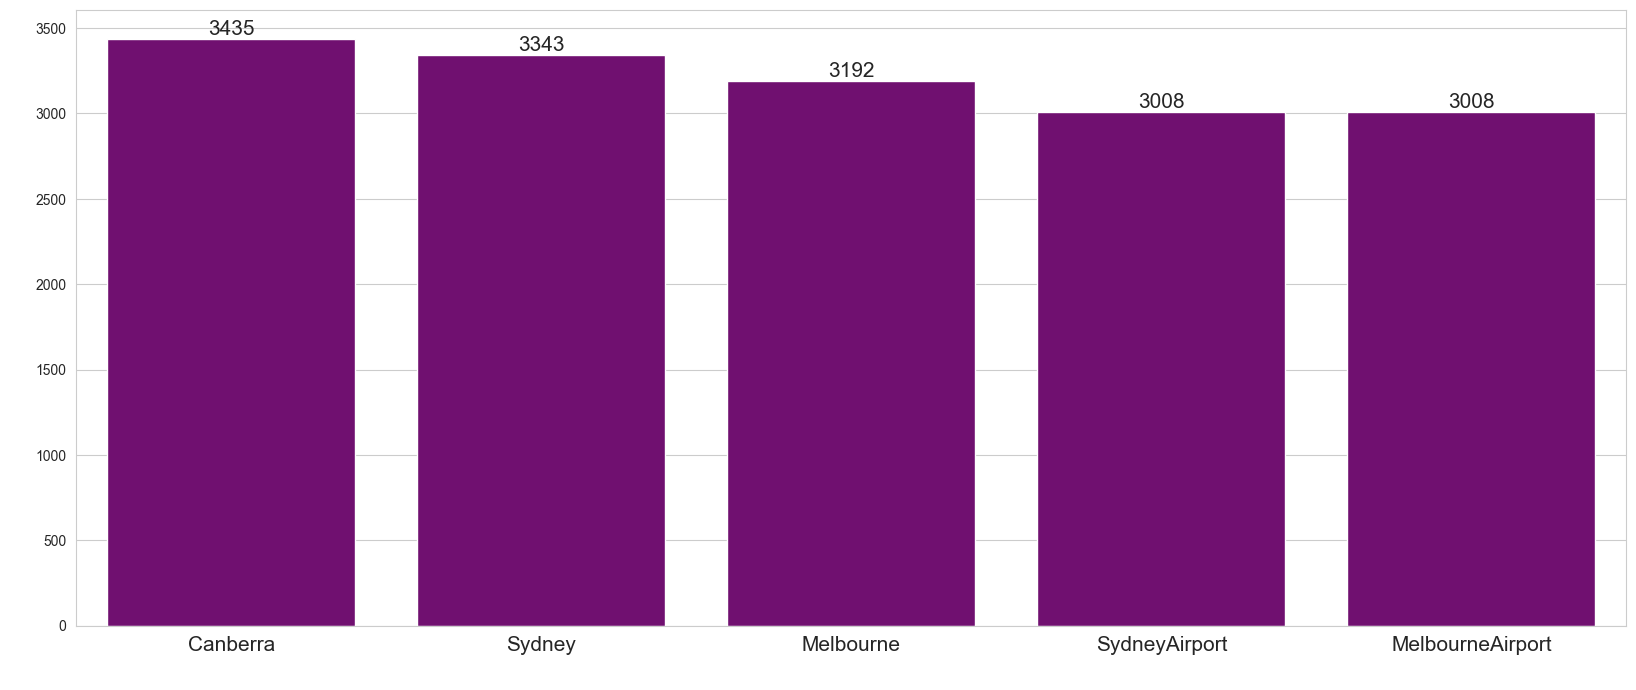

In [16]:
#Agregamos data labels a cada columna 
top = data['Location'].value_counts().sort_values(ascending=False)[0:30]

sns.set_style("whitegrid")

plt.figure(figsize=(20, 8))

ax = sns.barplot(x=top.index, y=top.values, color='purple')

ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)

for i, v in enumerate(top.values):
    ax.text(i, v, str(v), fontsize=15, ha='center', va='bottom')

ax.set_xlabel(' ', fontsize=16)
ax.set_ylabel(' ', fontsize=16)


plt.xticks(rotation=0)

plt.show()


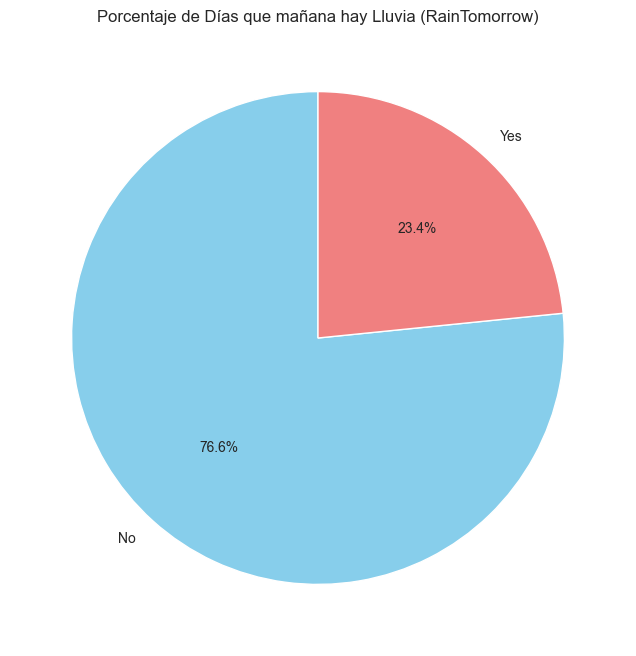

In [17]:
top = data['RainTomorrow'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 8))
top.plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Porcentaje de Días que mañana hay Lluvia (RainTomorrow)')
plt.ylabel('')  
plt.show()

Podemos ver que nuestra variable target de clasificacion esta ampliamente desbalanceada

In [18]:
#Ahora que el data set es más chico, ya que nos quedamos solo con las columnas que necesitamos
print('Cantidad de filas del data set:', data.shape[0])


Cantidad de filas del data set: 15986


In [19]:
#Calculamos la cantidad de valores nulos
nulos_por_columna = data.isnull().sum()

#Acomodamos los datos para poder ponerle titulo a las dos columnas que nos devuelve data.isnull().sum
nombres_columnas = ['Nombre_Columna', 'Cantidad_Nulos']  
nulos_con_nombres = pd.DataFrame({'Nombre_Columna': nulos_por_columna.index, 'Cantidad_Nulos': nulos_por_columna.values})

print('Cantidad de nulos por columna')
print(nulos_con_nombres)


Cantidad de nulos por columna
      Nombre_Columna  Cantidad_Nulos
0               Date               0
1           Location               0
2            MinTemp             487
3            MaxTemp             481
4           Rainfall             787
5        Evaporation            1706
6           Sunshine            1948
7          RainToday             787
8       RainTomorrow             787
9   RainfallTomorrow             787
10           WindDir             235
11         WindSpeed             229
12          Humidity             499
13          Pressure             706
14             Cloud            2366


In [20]:
#¿Qué porcentaje de nulos hay en cada columna?
#Calculamos la cantidad de valores nulos como porcentaje
porcentaje_nulos = (data.isnull().sum() / data.shape[0] * 100).round(2)

#Creamos un nuevo DataFrame con nombres de columnas personalizados
nombres_columnas = ['Nombre de columna', 'Porcentaje de nulos']  # Cambia 'Nombre de columna' y 'Porcentaje de nulos' a los nombres que desees
porcentaje_nulos_con_nombres = pd.DataFrame({'Nombre de columna': porcentaje_nulos.index, 'Porcentaje de nulos': porcentaje_nulos.values})

print(porcentaje_nulos_con_nombres)

   Nombre de columna  Porcentaje de nulos
0               Date                 0.00
1           Location                 0.00
2            MinTemp                 3.05
3            MaxTemp                 3.01
4           Rainfall                 4.92
5        Evaporation                10.67
6           Sunshine                12.19
7          RainToday                 4.92
8       RainTomorrow                 4.92
9   RainfallTomorrow                 4.92
10           WindDir                 1.47
11         WindSpeed                 1.43
12          Humidity                 3.12
13          Pressure                 4.42
14             Cloud                14.80


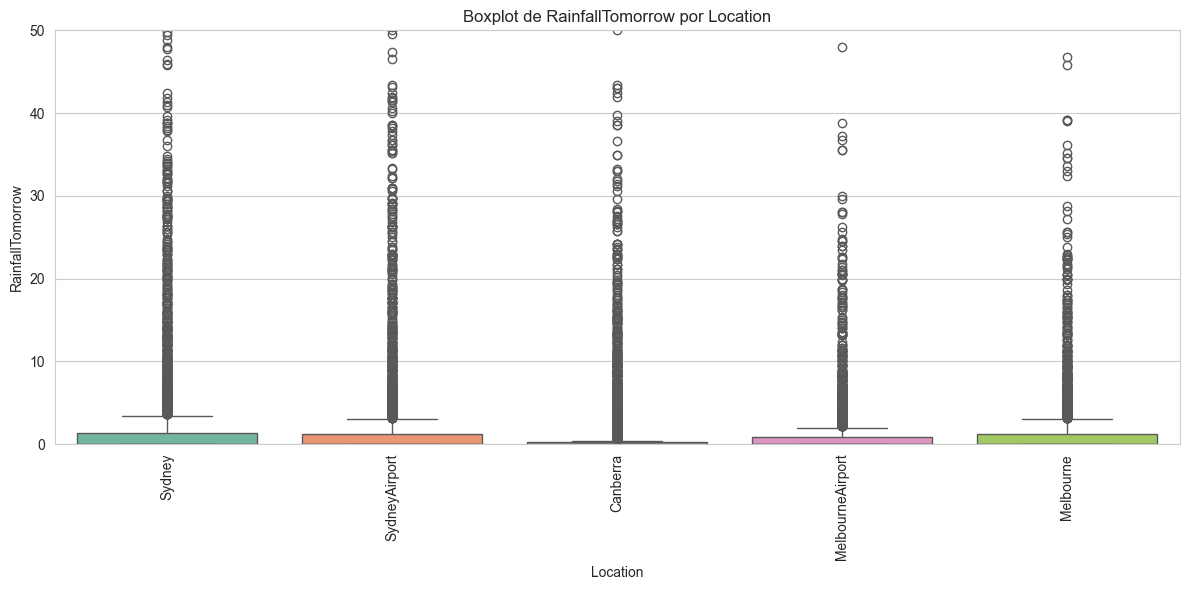

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='RainfallTomorrow', data=data, palette='Set2')

plt.xticks(rotation=90) 
plt.title('Boxplot de RainfallTomorrow por Location')
plt.xlabel('Location')
plt.ylabel('RainfallTomorrow')
plt.ylim(0, 50)

plt.tight_layout()
plt.show()

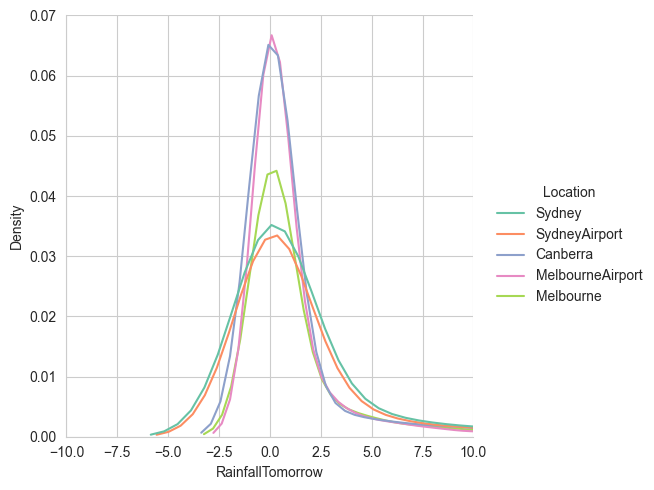

In [22]:
sns.displot(hue='Location', x='RainfallTomorrow', data=data, palette='Set2', kind='kde')

plt.xlim(-10, 10) 

plt.show()

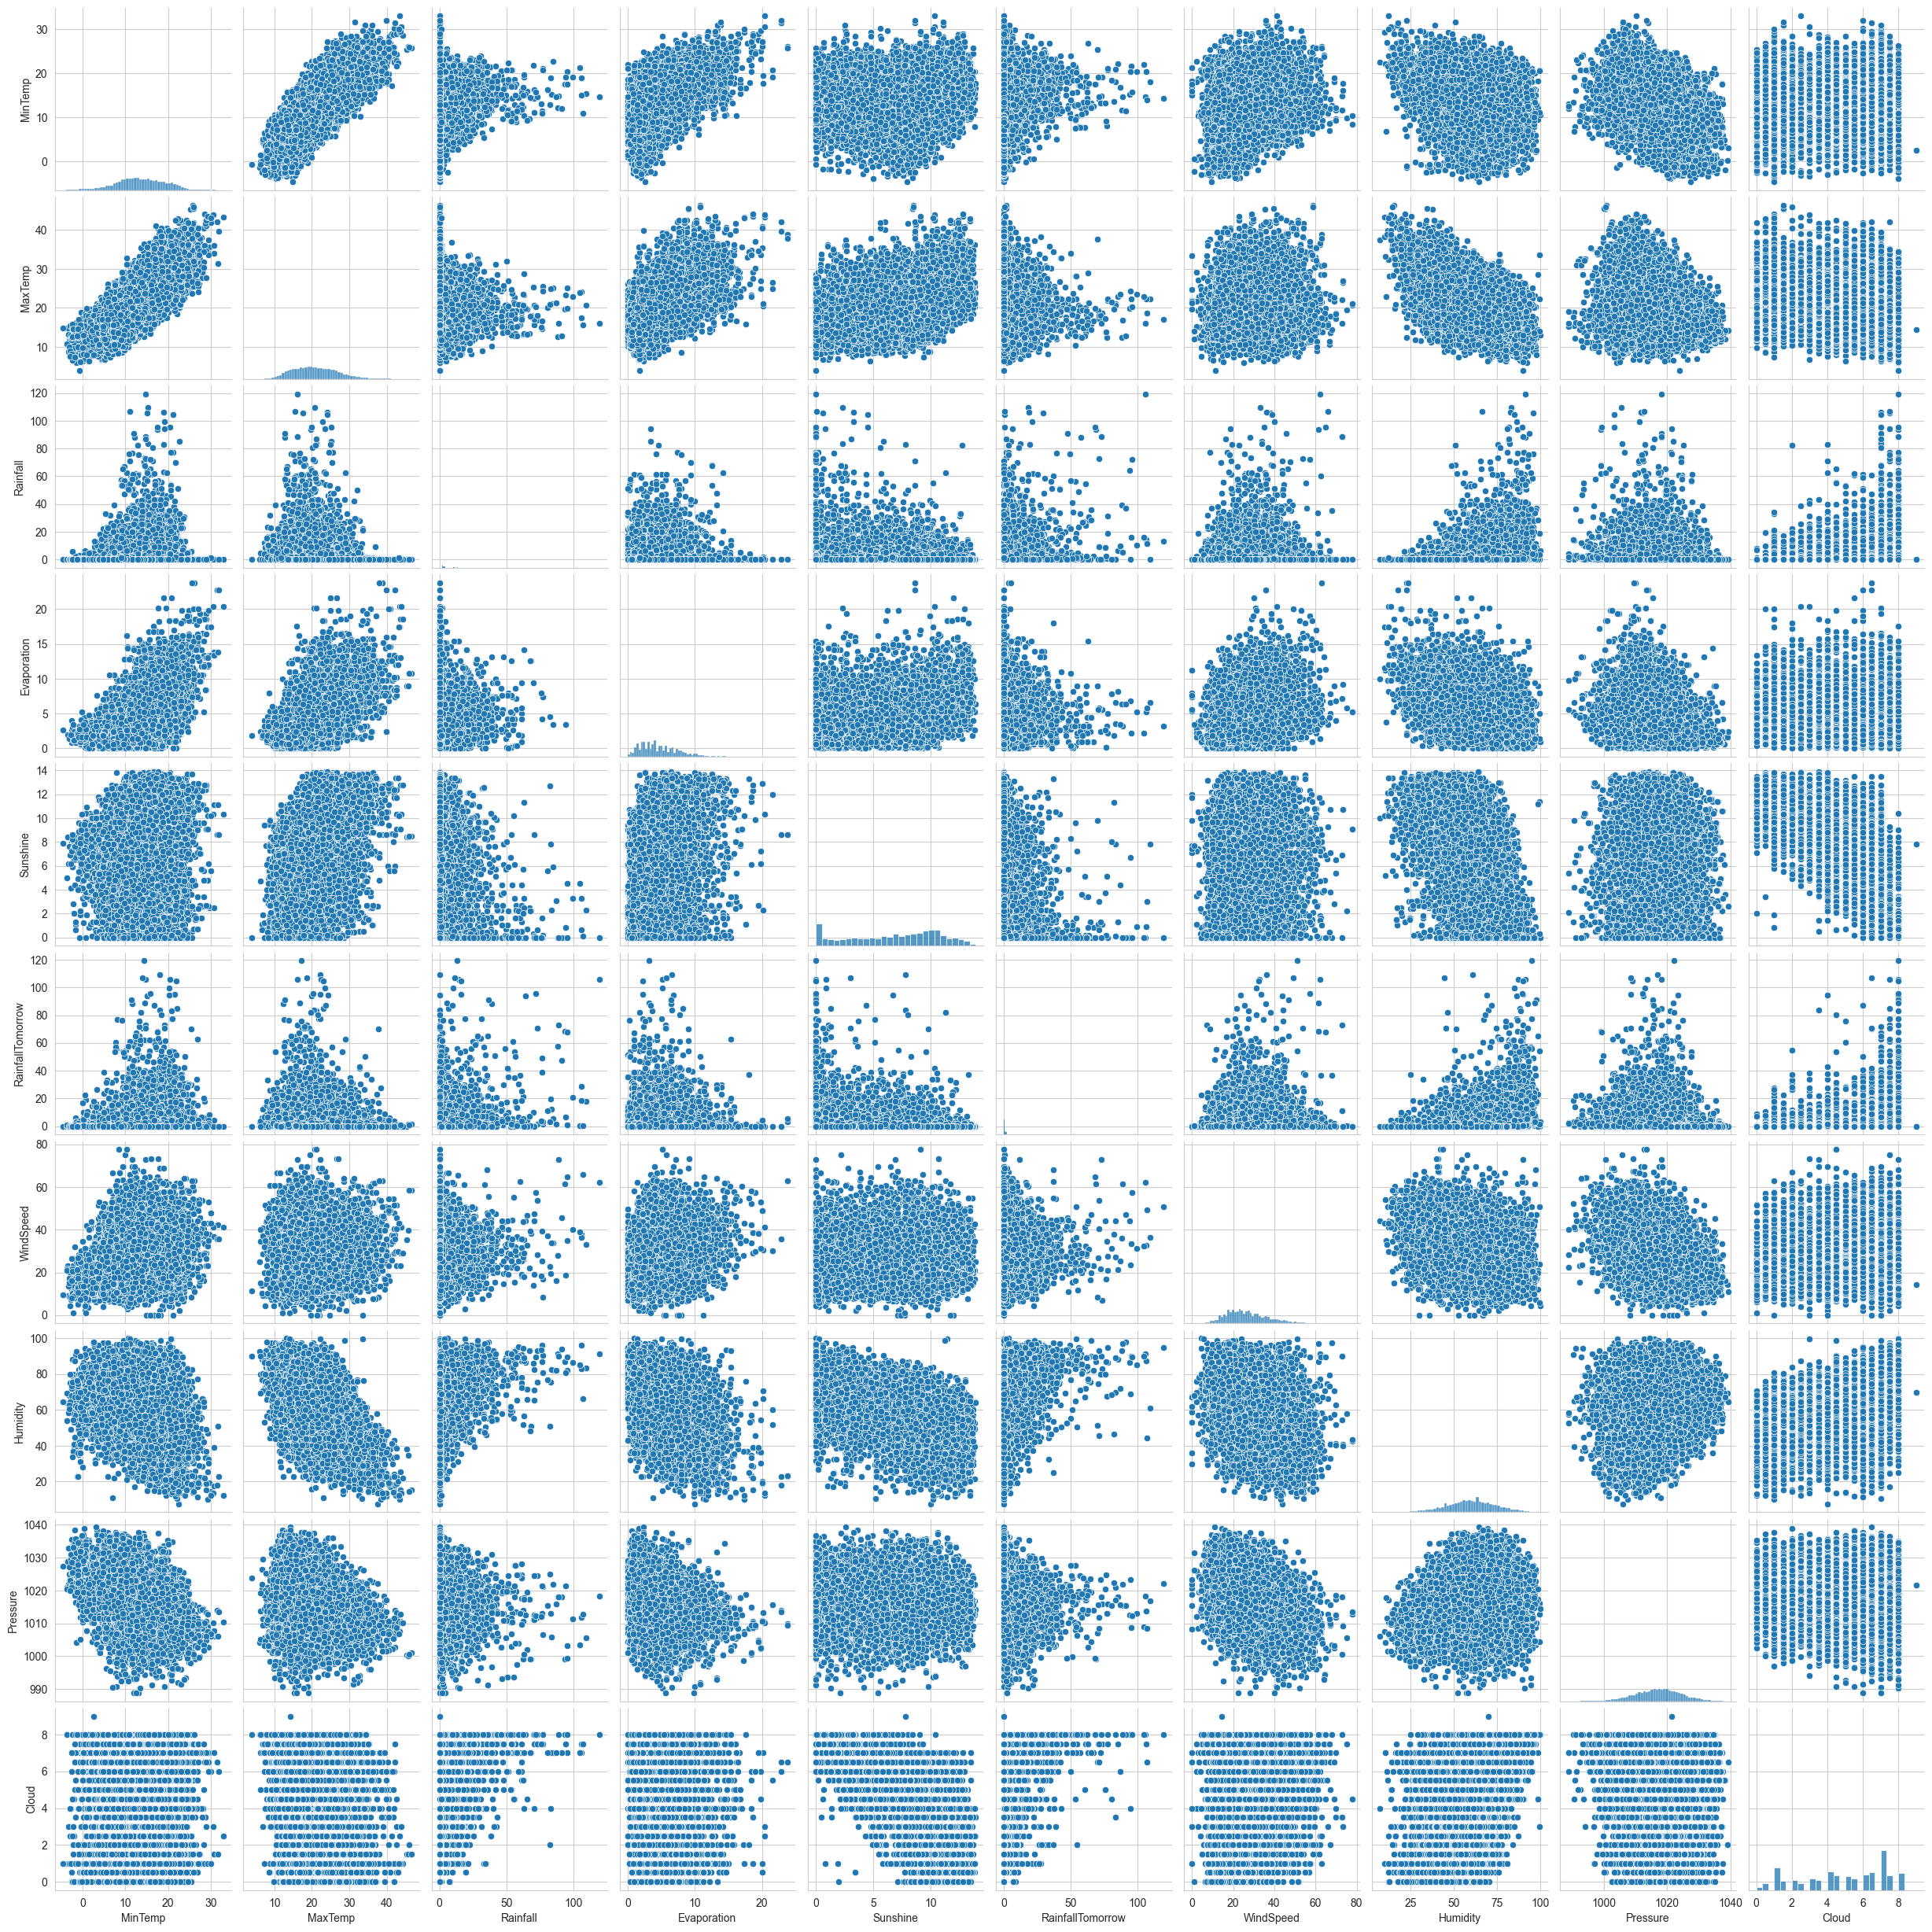

In [23]:
sns.pairplot(data)

## Transformación de variables categóricas

Descompones la columana 'Date' en sus componentes indivudales, es decir: año, mes, día agregamos esta columna y una más que guarda el día de la semana, la función day_of_week devuelve 0 para lunes, 1 para el domingo y así sucesivamente hasta el domingo.

In [24]:
data['Date'] = pd.to_datetime(data['Date'])
data['Año'] = data['Date'].dt.year
data['Mes'] = data['Date'].dt.month
data['Dia'] = data['Date'].dt.day

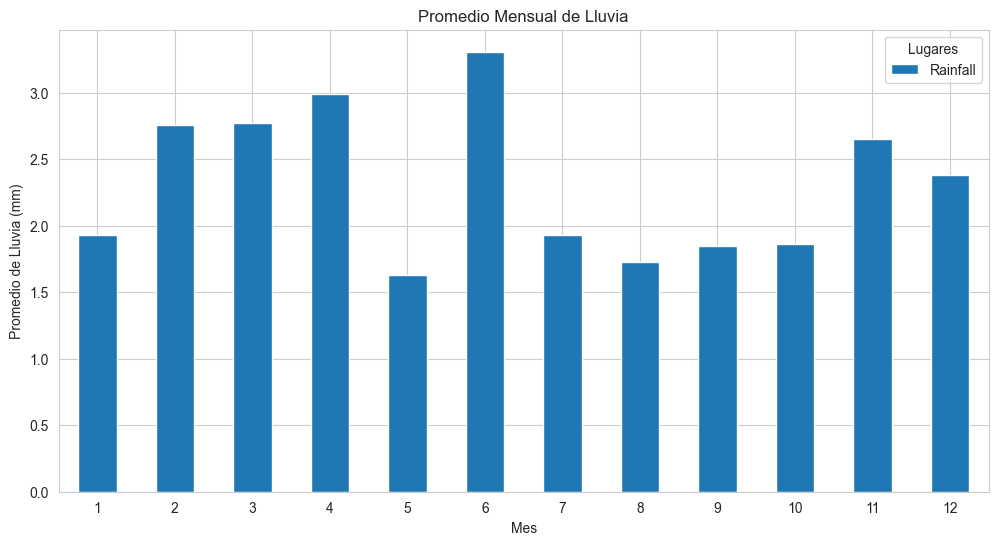

In [25]:
#Graficamos el promedio de lluvia por mes, consdierando todos los años del dataset
promedio_mensual = data.groupby(['Mes'])['Rainfall'].mean()
promedio_mensual.plot(kind='bar', figsize=(12, 6))
plt.title('Promedio Mensual de Lluvia')
plt.xlabel('Mes')
plt.ylabel('Promedio de Lluvia (mm)')
plt.xticks(rotation=0)
plt.legend(title='Lugares', loc='upper right')
plt.show()

De dicho gráfico podemos observar que los meses con mayor cantidad de lluvia son junio, marzo y noviembre.

In [26]:
anios = data.Año.unique() 
print(f"Cantidad de años que tenemos datos: {len(anios)}. Estos son: {anios}",) 

Cantidad de años que tenemos datos: 11. Estos son: [2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2007]


Veamos la correlacion de las variables

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 30167 to 70370
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              15986 non-null  datetime64[ns]
 1   Location          15986 non-null  object        
 2   MinTemp           15499 non-null  float64       
 3   MaxTemp           15505 non-null  float64       
 4   Rainfall          15199 non-null  float64       
 5   Evaporation       14280 non-null  float64       
 6   Sunshine          14038 non-null  float64       
 7   RainToday         15199 non-null  object        
 8   RainTomorrow      15199 non-null  object        
 9   RainfallTomorrow  15199 non-null  float64       
 10  WindDir           15751 non-null  object        
 11  WindSpeed         15757 non-null  float64       
 12  Humidity          15487 non-null  float64       
 13  Pressure          15280 non-null  float64       
 14  Cloud             13620

## Matriz de correlacion y analisis de variables

Con el fin de identificar patrones de correlación en los datos, calculamos la matriz de corrlación entre todas las columnas del dataset, en 2 ocasiones, primero comparando contra la columna 'RainfallTomorrow', para analizar las 'features' que participaran en el modelo de regresion, y luego comparando contra 'RainTomorrow_Yes' para analizar lo mismo pero en el modelo de clasificacion
En este caso vamos analizar lo siguiente:
- Si el coeficiente de correlación es cercano a 1, indica una correlación positiva fuerte, lo que significa que a medida que una variable aumenta, la otra también tiende a aumentar.
- Si el coeficiente de correlación es cercano a -1, indica una correlación negativa fuerte, lo que significa que a medida que una variable aumenta, la otra tiende a disminuir.
- Si el coeficiente de correlación es cercano a 0, indica que no hay una correlación lineal fuerte entre las dos variables.

In [28]:
numeric_features = data.select_dtypes(include=['float64' , 'int32']).columns.tolist()
numeric_features.remove('RainfallTomorrow')

In [29]:
corr_reg = data[["RainfallTomorrow"] + numeric_features].corr()


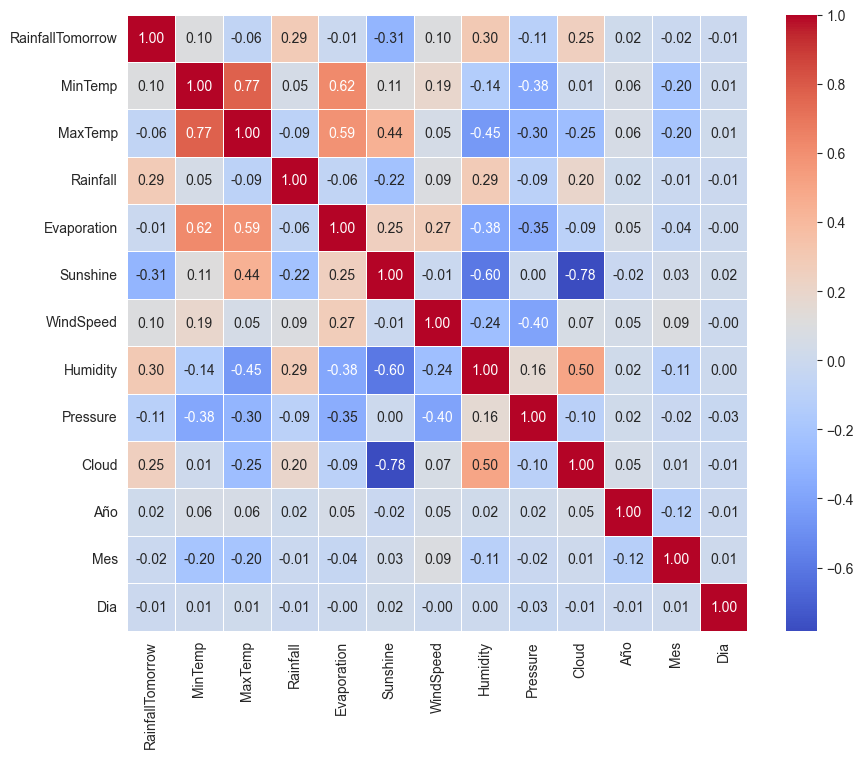

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_reg, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.show()

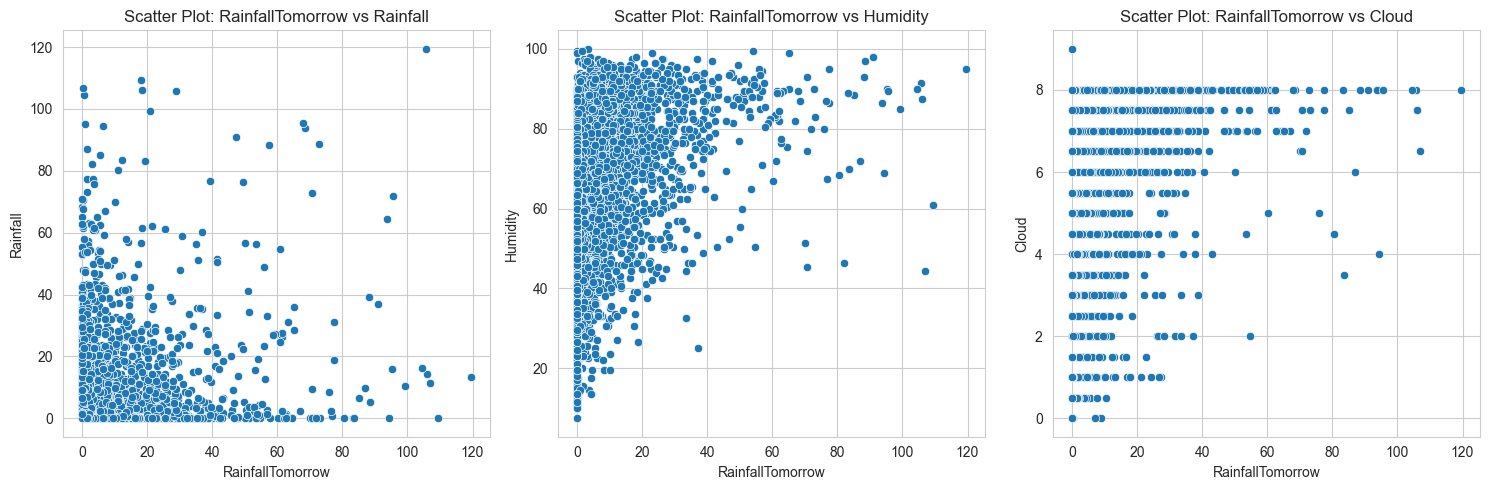

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=data, x='RainfallTomorrow', y='Rainfall')
plt.title('Scatter Plot: RainfallTomorrow vs Rainfall')

plt.subplot(1, 3, 2)
sns.scatterplot(data=data, x='RainfallTomorrow', y='Humidity')
plt.title('Scatter Plot: RainfallTomorrow vs Humidity')

plt.subplot(1, 3, 3)
sns.scatterplot(data=data, x='RainfallTomorrow', y='Cloud')
plt.title('Scatter Plot: RainfallTomorrow vs Cloud')

plt.tight_layout()

plt.show()

Podemos ver que las mayores lluvias se dan cuando mas humedad hubo el dia anterior, que tiene logica, o tambien cuando hubo mas nubosidad.

# Dividimos el Dataframe en Train y Test

In [32]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

## Inputamos los datos faltantes

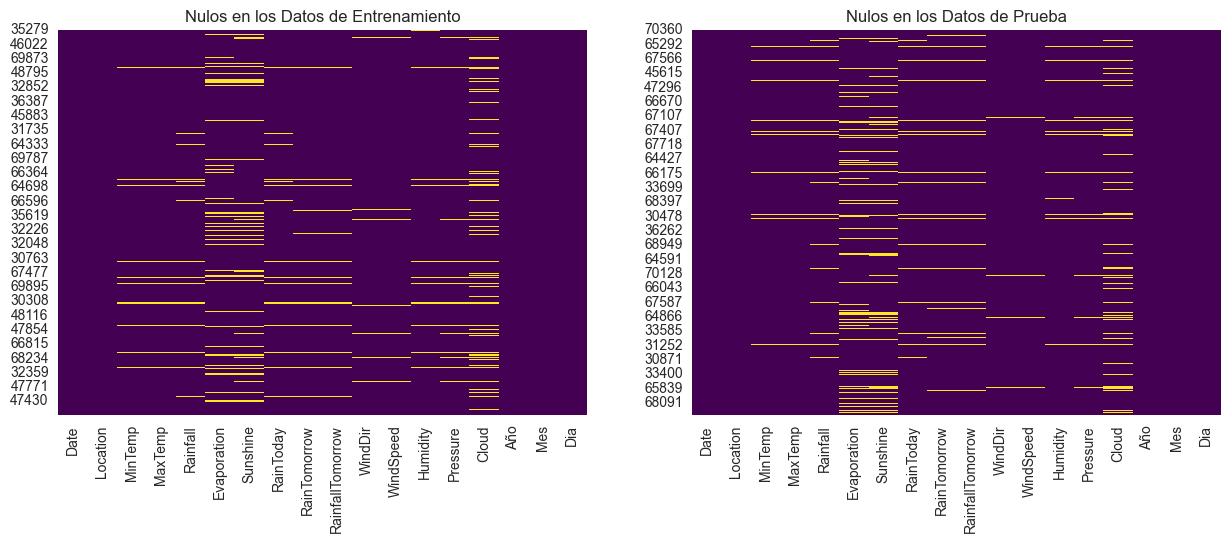

In [33]:
datos_train = train_data.isnull()
datos_test = test_data.isnull()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.heatmap(datos_train , ax=axes[0], cmap='viridis', cbar=False)
axes[0].set_title('Nulos en los Datos de Entrenamiento')


sns.heatmap(datos_test, ax=axes[1], cmap='viridis', cbar=False)
axes[1].set_title('Nulos en los Datos de Prueba')

plt.show()

La decisión tomada para rellenar los datos nulos es rellenar los mismos con el valor de la fecha de la misma fecha del año pasado, si es que existe, ya que también podría ser nulo.
A continuación se encuentra el código que realice esta modificación de los datos 

In [34]:
def Inputado(data):
    Inputar = ['MinTemp', 'MaxTemp','Evaporation', 'Sunshine', 'Rainfall', 'Humidity' , 'Pressure','Cloud', 'WindSpeed', 'RainToday', 'RainTomorrow', 'RainfallTomorrow']
    data = data.sort_values(by='Date')
    for variable in Inputar:
    #Rellenamos los valores nulos con el valor de la fecha del año pasado si existe
        data[variable] = data[variable].fillna(data[variable].shift())
    return data

Inputamos los dataframe separados

In [35]:
train_data = Inputado(train_data)
test_data = Inputado(test_data)

¿Mejoraron la cantidad de nulos por columna? Lo vemos en el gráfico que se muestra a continuación

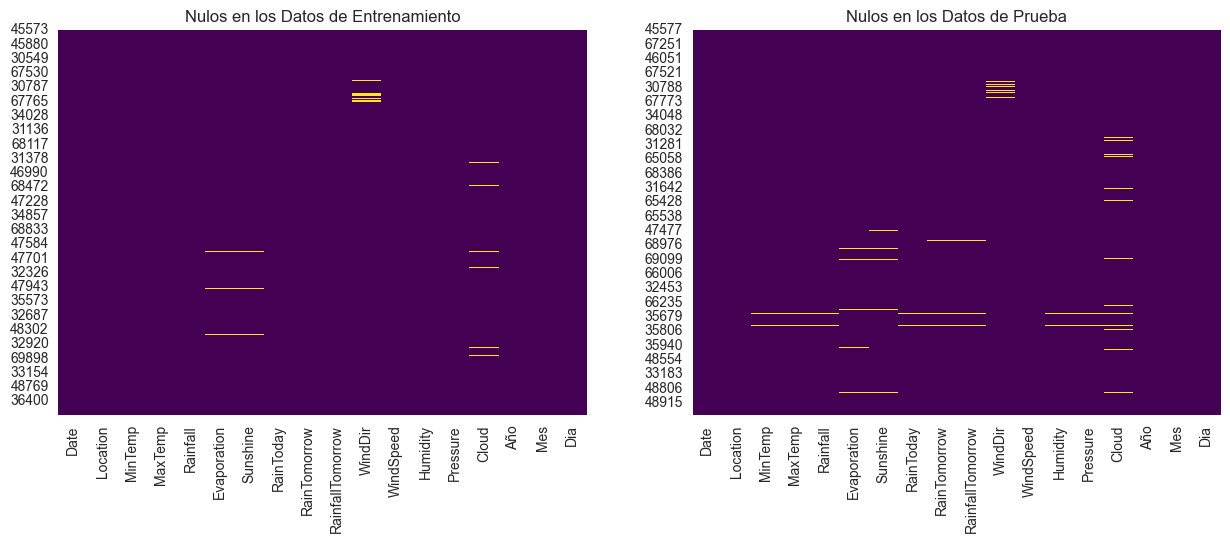

In [36]:
datos_train = train_data.isnull()
datos_test = test_data.isnull()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.heatmap(datos_train , ax=axes[0], cmap='viridis', cbar=False)
axes[0].set_title('Nulos en los Datos de Entrenamiento')


sns.heatmap(datos_test, ax=axes[1], cmap='viridis', cbar=False)
axes[1].set_title('Nulos en los Datos de Prueba')

plt.show()

Comprando este gráfico con el realizado antes de empezar a realizar el tratamiento de los datos nulos, podemos ver que ha mejorado significatiavamente.
Analizamos a continaución en profundidad los resultados obtenidos.

In [37]:
train_missing_ratio = train_data.isnull().sum() / train_data.shape[0]
test_missing_ratio = test_data.isnull().sum() / test_data.shape[0]

missing_data_df = pd.DataFrame({
    'Train Data': train_missing_ratio,
    'Test Data': test_missing_ratio
})

missing_data_df

Train Data  Test Data
Date                0.000000   0.000000
Location            0.000000   0.000000
MinTemp             0.002190   0.004378
MaxTemp             0.002190   0.004065
Rainfall            0.002581   0.005003
Evaporation         0.007038   0.016260
Sunshine            0.006490   0.019074
RainToday           0.002581   0.005003
RainTomorrow        0.002581   0.005941
RainfallTomorrow    0.002581   0.005941
WindDir             0.014701   0.014697
WindSpeed           0.000626   0.002502
Humidity            0.002190   0.004378
Pressure            0.002737   0.006567
Cloud               0.022599   0.025641
Año                 0.000000   0.000000
Mes                 0.000000   0.000000
Dia                 0.000000   0.000000

Consideramos que el porcentaje de nulos ya es lo suficiente bajo, para que los pocos nulos que quedan no afecten el resultado final la decisión que tomamos es eliminarlos, como se puede ver en el código que desarrollamos a continuación. 

In [38]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [39]:
#Chequeamos que efectivamento no haya más nulos
train_missing_ratio = train_data.isnull().sum() / train_data.shape[0]
test_missing_ratio = test_data.isnull().sum() / test_data.shape[0]

missing_data_df = pd.DataFrame({
    'Train Data': train_missing_ratio,
    'Test Data': test_missing_ratio
})

missing_data_df

Train Data  Test Data
Date                     0.0        0.0
Location                 0.0        0.0
MinTemp                  0.0        0.0
MaxTemp                  0.0        0.0
Rainfall                 0.0        0.0
Evaporation              0.0        0.0
Sunshine                 0.0        0.0
RainToday                0.0        0.0
RainTomorrow             0.0        0.0
RainfallTomorrow         0.0        0.0
WindDir                  0.0        0.0
WindSpeed                0.0        0.0
Humidity                 0.0        0.0
Pressure                 0.0        0.0
Cloud                    0.0        0.0
Año                      0.0        0.0
Mes                      0.0        0.0
Dia                      0.0        0.0

Eliminamos la columna Date de los dataframes

In [40]:
train_data.drop(columns= "Date", inplace=True, axis= 1)
test_data.drop(columns= "Date", inplace=True, axis= 1)

Exporto los DataFrames en csv para continuar con los modelos

In [41]:
train_data.to_csv('train_data.csv', index=False)

test_data.to_csv('test_data.csv', index=False)